# **Transfer Learning**
<img align='right' width='500' src="https://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1516368587/transfer-learning_2x_hjrupn.png">

- Transfer learning is a machine learning technique where a model trained on one task is re-purposed on a second related task.
- In transfer learning, we first train a base network on a base dataset and task, and then we repurpose the learned features, or transfer them, to a second target network to be trained on a target dataset and task. This process will tend to work if the features are general, meaning suitable to both base and target tasks, instead of specific to the base task.

<br>
<br>

- There is to major type of transfer learning:
    1. **fine-tuning** strategy all weights are changed when training on the new task (except for the weights of the last layers for the original task)
    2. **feature extraction** strategy only the weights of the newly added last layers change during the training phase
<img align="center" width="600" src="https://i.stack.imgur.com/BiClc.png">

In [1]:
import numpy as np
import cv2
import PIL
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

## **Trainable Layers**

Layers & models have **three** weight attributes:
```
- weights
- trainable_weights
- non_trainable_weights
```
for example: the `Dense` layer has 2 trainable weights (kernel & bias)

In [2]:
layer = keras.layers.Dense(4)

# Create the weights using layer.build
layer.build((None, 2))

print(f'Number of weights: {len(layer.weights)}')
print(f'Number of trainable_weights: {len(layer.trainable_weights)}')
print(f'Number of non_trainable_weights: {len(layer.non_trainable_weights)}')

Number of weights: 2
Number of trainable_weights: 2
Number of non_trainable_weights: 0


### **Layers & models** also feature a boolean attribute `trainable`.

**"freezing"**

- By setting `layer.trainable` to `False` moves all the layer's weights from trainable to non-trainable.  

- the state of a frozen layer won't be updated during training (either when training with `fit()` or when training with any custom loop that relies on `trainable_weights` to apply gradient updates).

**Note: `.trianable` is Recursive**, meaning that on any layer that has sublayers, all children layers become non-trainable as well.

for example: setting `trainable` to `False`

In [3]:
# Make a model with 2 layers
layer1 = keras.layers.Dense(3, activation="relu")
layer2 = keras.layers.Dense(3, activation="sigmoid")
model = keras.Sequential([keras.Input(shape=(3,)), layer1, layer2])

# Freeze the first layer
layer1.trainable = False

# Keep a copy of the weights of layer1 for later reference
initial_layer1_weights_values = layer1.get_weights()

# Train the model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.mean_squared_error)
model.fit(np.random.random((2, 3)), np.random.random((2, 3)))

1/1 [==============================] - 8s 8s/step - loss: 0.0642


In [4]:
final_layer1_weights_values = layer1.get_weights()

if initial_layer1_weights_values[0].all() == final_layer1_weights_values[0].all():
  print('Weights unchanged')

if initial_layer1_weights_values[1].all() == final_layer1_weights_values[1].all():
  print('Weights unchanged')

Weights unchanged
Weights unchanged


## **Implementing Transfer Learning**

<img src="https://www.freetimelearning.com/images/interview_questions/transfer_learning.jpg" width="400" align="right">

1. We instantiate a **base model and load pre-trained weighs** into it.
2. **Freeze** all layers in the base model by setting `trainable = False`.
3. Create a **new model on top** of the output of one (or several) layers from the base
 model.
4. Train your new model on your new dataset.

In [6]:
tfds.disable_progress_bar()

train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    # Reserve 10% for validation and 10% for test
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True,  # Include labels
)

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [7]:
# fig = plt.figure(figsize=(10, 10))
# row, col = 3, 3
# for i in range(row * col + 1):
#     idx = np.random.randint((len(train_ds)))
#     fig.add_subplot(row, col, i + 1)
#     plt.imshow(image)
#     plt.title('Cat' if int(label) == 0 else 'Dog')
#     plt.axis("off")

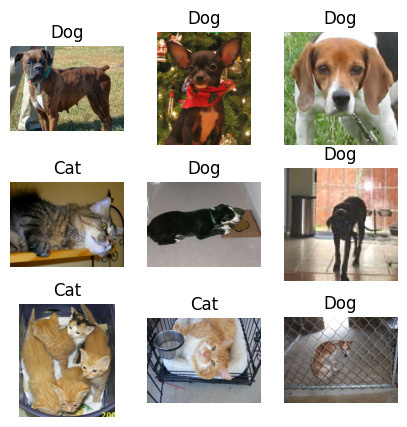

In [8]:
fig = plt.figure(figsize=(5, 5))
row, col = 3, 3
for i, (image, label) in enumerate(train_ds.take(9)):
    fig.add_subplot(row, col, i + 1)
    plt.imshow(image)
    plt.title('Cat' if int(label) == 0 else 'Dog')
    plt.axis(False)

## **Preprocess Our Data**

- Preprocess to a fixed image size. We pick 150x150.
- Normalize pixel values between -1 and 1. We'll do this using a `Normalization` layer
- Data augmentation

In [9]:
size = (150, 150)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))

In [10]:
batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

In [11]:
data_augmentation = keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

## **Building the model**

- We add a `Dropout` layer before the classification layer, for regularization.
- We make sure to pass `training=False` when calling the base model, so that
it runs in inference mode, so that batchnorm statistics don't get updated
even after we unfreeze the base model for fine-tuning.

In [12]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,  # Removethe ImageNet classifier at the top.
)

# Freeze the base_model
base_model.trainable = False

# Create new layers on top
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

83683744/83683744 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0      

In [13]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 10
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/10
291/291 [==============================] - 37s 100ms/step - loss: 0.1821 - binary_accuracy: 0.9235 - val_loss: 0.0810 - val_binary_accuracy: 0.9695
Epoch 2/10
291/291 [==============================] - 23s 79ms/step - loss: 0.1146 - binary_accuracy: 0.9508 - val_loss: 0.0781 - val_binary_accuracy: 0.9716
Epoch 3/10
291/291 [==============================] - 23s 79ms/step - loss: 0.1077 - binary_accuracy: 0.9552 - val_loss: 0.0728 - val_binary_accuracy: 0.9725
Epoch 4/10
291/291 [==============================] - 24s 84ms/step - loss: 0.1043 - binary_accuracy: 0.9559 - val_loss: 0.0711 - val_binary_accuracy: 0.9738
Epoch 5/10
291/291 [==============================] - 24s 84ms/step - loss: 0.1065 - binary_accuracy: 0.9563 - val_loss: 0.0726 - val_binary_accuracy: 0.9729
Epoch 6/10
291/291 [==============================] - 23s 80ms/step - loss: 0.0957 - binary_accuracy: 0.9593 - val_loss: 0.0708 - val_binary_accuracy: 0.9742
Epoch 7/10
291/291 [==============================]

## **Fine Tuning**

<img src="https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/05-transfer-learning-feature-extraction-vs-fine-tuning.png" width="400" align="right">

- We **unfreeze** the base model and train the entire model end-to-end with a **low** learning rate.

**Notes** although the base model becomes trainable, it is still running in inference mode since we passed `training=False` when calling it when we built the model.
  - This means that the batch normalization layers inside won't update their batch statistics. If they did, they would wreck havoc on the representations learned by the model so far.

In [15]:
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                             

In [17]:
# epochs = 3
# model.fit(train_ds, epochs=epochs, validation_data=validation_ds)